# Capstone #3

## Objectives


    How many customers joined the company during the last quarter? How many customers joined?

    What is the customer profile for a customer that churned, joined, and stayed? Are they different?

    What seem to be the key drivers of customer churn?

    Is the company losing high value customers? If so, how can they retain them?



## 1. Sourcing and Loading Data
Data sources:
            https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics?select=telecom_zipcode_population.csv




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import lightgbm

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


pd.options.display.max_columns = None
#pd.options.display.max_rows = None
pd.options.display.max_colwidth = None


In [2]:
# Location of invididual CSV files being used
data_dictionary = pd.read_csv("../data/telecom_data_dictionary.csv", encoding = "ISO-8859-1")
customer_churn = pd.read_csv("../Data/telecom_customer_churn.csv") 
zipcodes = pd.read_csv("../Data/telecom_zipcode_population.csv")


### Previewing Data Dictionary DF
Reference table requiring no further cleaning

In [3]:
data_dictionary

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customers gender: Male, Female"
2,Customer Churn,Age,"The customers current age, in years, at the time the fiscal quarter ended (Q2 2022)"
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,"Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)"
5,Customer Churn,City,The city of the customers primary residence in California
6,Customer Churn,Zip Code,The zip code of the customers primary residence
7,Customer Churn,Latitude,The latitude of the customers primary residence
8,Customer Churn,Longitude,The longitude of the customers primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has referred a friend or family member to this company to date


### Previewing customer_churn table

In [4]:
print(customer_churn.shape)
customer_churn.head()

(7043, 38)


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [5]:
customer_churn.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


In [6]:
customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

### Previewing Zipcodes table

In [7]:
print(zipcodes.shape)
zipcodes.head()

(1671, 2)


,Zip Code,Population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


In [8]:
zipcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Zip Code    1671 non-null   int64
 1   Population  1671 non-null   int64
dtypes: int64(2)
memory usage: 26.2 KB


In [9]:
zipcodes.isnull().sum()

Zip Code      0
Population    0
dtype: int64

In [10]:
zipcodes.min(), zipcodes.max()

(Zip Code      90001
 Population       11
 dtype: int64,
 Zip Code       96161
 Population    105285
 dtype: int64)

In [11]:
print(zipcodes.nunique())

Zip Code      1671
Population    1607
dtype: int64


In [12]:
#Duplicated values appear to be valid, not entry error.
zipcodes[zipcodes.duplicated(subset=['Population'], keep=False)].sort_values(by='Population')

,Zip Code,Population
60,90071,21
1168,95232,21
1547,95978,28
728,93435,28
806,93623,77
...,...,...
613,92887,20893
881,94002,25566
148,90746,25566
370,92120,25569


### Merging tables into one comprehensive dataframe

In [13]:
#Creating merged data frame to include zipcode data
zipcodes = zipcodes.rename(columns={"Population": "Zip Code Population"})
df = customer_churn.merge(zipcodes, on ="Zip Code", how= 'left')
df = df.drop(['Customer ID', 'Latitude', 'Longitude', 'City'], axis=1)
print(df.shape)
df.head()

(7043, 35)


,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population
0,Female,37,Yes,0,93225,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,Male,46,No,0,91206,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
2,Male,50,No,0,92627,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069
3,Male,78,Yes,0,94553,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677
4,Female,75,Yes,0,93010,3,3,None,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853


## 2. Cleaning Data

In [14]:
df.isnull().sum()

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
Zip Code                                0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                     1526
Streaming Music                      1526
Unlimited Data                       1526
Contract                                0
Paperless Billing                 

In [15]:
df[df.isna().any(axis=1)]

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population
0,Female,37,Yes,0,93225,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,Male,46,No,0,91206,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
5,Female,23,No,3,95345,0,9,Offer E,Yes,16.77,No,Yes,Cable,73.0,No,No,No,Yes,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Credit Card,69.40,571.45,0.00,0,150.93,722.38,Stayed,NaN,NaN,433
6,Female,67,Yes,0,93437,1,71,Offer A,Yes,9.96,No,Yes,Fiber Optic,14.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal,109.70,7904.25,0.00,0,707.16,8611.41,Stayed,NaN,NaN,6165
7,Male,52,Yes,0,94558,8,63,Offer B,Yes,12.96,Yes,Yes,Fiber Optic,7.0,Yes,No,No,Yes,No,No,No,No,Two Year,Yes,Credit Card,84.65,5377.80,0.00,20,816.48,6214.28,Stayed,NaN,NaN,63947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,36,No,0,92028,0,4,None,Yes,2.01,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-Month,No,Bank Withdrawal,20.95,85.50,0.00,0,8.04,93.54,Churned,Competitor,Competitor made better offer,42239
7038,Female,20,No,0,91941,0,13,Offer D,Yes,46.68,No,Yes,DSL,59.0,Yes,No,No,Yes,No,No,Yes,Yes,One Year,No,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN,44652
7040,Male,22,No,0,95432,0,2,Offer E,Yes,18.62,No,Yes,DSL,51.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN,383
7041,Male,21,Yes,0,92075,5,67,Offer A,Yes,2.12,No,Yes,Cable,58.0,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Two Year,No,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN,12173


In [16]:
#Identifying columns with N/A Churn Reason
df[(df['Customer Status'] == 'Stayed')| (df['Customer Status'] == 'Joined')]
#Result matches the 5174 missing values in "Churn Category" & "Churn Reason" columns

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population
0,Female,37,Yes,0,93225,2,9,None,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,Male,46,No,0,91206,0,9,None,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
5,Female,23,No,3,95345,0,9,Offer E,Yes,16.77,No,Yes,Cable,73.0,No,No,No,Yes,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Credit Card,69.40,571.45,0.00,0,150.93,722.38,Stayed,NaN,NaN,433
6,Female,67,Yes,0,93437,1,71,Offer A,Yes,9.96,No,Yes,Fiber Optic,14.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal,109.70,7904.25,0.00,0,707.16,8611.41,Stayed,NaN,NaN,6165
7,Male,52,Yes,0,94558,8,63,Offer B,Yes,12.96,Yes,Yes,Fiber Optic,7.0,Yes,No,No,Yes,No,No,No,No,Two Year,Yes,Credit Card,84.65,5377.80,0.00,20,816.48,6214.28,Stayed,NaN,NaN,63947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,Female,20,No,0,90022,0,7,Offer E,Yes,36.49,No,Yes,Fiber Optic,42.0,No,Yes,No,No,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,94.05,633.45,0.00,0,255.43,888.88,Stayed,NaN,NaN,68701
7038,Female,20,No,0,91941,0,13,Offer D,Yes,46.68,No,Yes,DSL,59.0,Yes,No,No,Yes,No,No,Yes,Yes,One Year,No,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN,44652
7040,Male,22,No,0,95432,0,2,Offer E,Yes,18.62,No,Yes,DSL,51.0,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN,383
7041,Male,21,Yes,0,92075,5,67,Offer A,Yes,2.12,No,Yes,Cable,58.0,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Two Year,No,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN,12173


In [17]:
#Identifying Columns with N/A Long Distance Charges & Multiple Lines
df[df['Phone Service'] == 'No']
#Result matches the 682 missing values in "Avg Monthly Long Distance Charges" & "Multiple Lines" columns  

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population
10,Male,47,No,0,92091,0,54,None,No,NaN,NaN,Yes,Cable,10.0,Yes,No,No,Yes,Yes,No,No,Yes,Two Year,No,Credit Card,45.20,2460.55,0.0,0,0.0,2460.55,Stayed,NaN,NaN,1072
14,Female,39,No,0,93441,0,56,None,No,NaN,NaN,Yes,DSL,19.0,Yes,Yes,Yes,Yes,No,No,No,Yes,Two Year,No,Bank Withdrawal,45.05,2560.10,0.0,0,0.0,2560.10,Stayed,NaN,NaN,1317
16,Female,52,Yes,1,94956,0,34,None,No,NaN,NaN,Yes,DSL,20.0,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,One Year,No,Credit Card,61.25,1993.20,0.0,0,0.0,1993.20,Stayed,NaN,NaN,1885
19,Male,67,No,0,95037,0,1,None,No,NaN,NaN,Yes,Cable,9.0,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,25.10,25.10,0.0,0,0.0,25.10,Churned,Competitor,Competitor made better offer,41707
25,Female,37,Yes,1,92060,1,1,None,No,NaN,NaN,Yes,DSL,19.0,Yes,No,No,No,No,No,No,Yes,Month-to-Month,No,Bank Withdrawal,30.50,30.50,0.0,0,0.0,30.50,Churned,Attitude,Attitude of service provider,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,Female,75,No,0,96058,0,65,Offer B,No,NaN,NaN,Yes,Cable,9.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Two Year,Yes,Bank Withdrawal,53.50,3517.90,0.0,0,0.0,3517.90,Stayed,NaN,NaN,816
6980,Female,69,No,0,95984,0,1,Offer E,No,NaN,NaN,Yes,DSL,21.0,No,No,No,No,No,No,No,Yes,Month-to-Month,No,Credit Card,25.05,25.05,0.0,0,0.0,25.05,Churned,Competitor,Competitor had better devices,73
6996,Female,58,No,0,90742,0,12,Offer D,No,NaN,NaN,Yes,DSL,7.0,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Two Year,No,Credit Card,49.85,552.10,0.0,0,0.0,552.10,Stayed,NaN,NaN,1107
7016,Male,23,Yes,0,94089,7,69,None,No,NaN,NaN,Yes,DSL,42.0,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,60.80,4263.40,0.0,0,0.0,4263.40,Stayed,NaN,NaN,16985


In [18]:
#Identifying Columns with N/A Long Distance Charges & Multiple Lines
df[df['Internet Service'] == 'No']
#Result matches the 1526 missing values in following columns:
#Internet Type
# Avg Monthly GB Download
# Online Security
# Online Backup
# Device Protection Plan
# Premium Tech Support
# Streaming TV
# Streaming Movies
# Streaming Music
# Unlimited Data

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population
20,Female,79,Yes,0,93601,0,50,None,Yes,31.43,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One Year,No,Bank Withdrawal,25.20,1306.30,0.00,0,1571.50,2877.80,Stayed,NaN,NaN,1968
23,Female,22,No,0,93530,0,3,None,Yes,3.12,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-Month,No,Credit Card,19.85,57.20,0.00,0,9.36,66.56,Joined,NaN,NaN,71
24,Female,34,Yes,0,95550,0,4,Offer E,Yes,12.43,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-Month,No,Credit Card,20.35,76.35,0.00,0,49.72,126.07,Churned,Price,Long distance charges,155
27,Male,42,Yes,3,95358,3,54,None,Yes,19.70,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two Year,No,Credit Card,20.40,1090.60,0.00,0,1063.80,2154.40,Stayed,NaN,NaN,30668
28,Male,64,No,0,95442,0,26,Offer C,Yes,37.70,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One Year,Yes,Bank Withdrawal,19.60,471.85,21.25,0,980.20,1430.80,Stayed,NaN,NaN,4101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,Female,50,No,0,92518,0,6,Offer E,Yes,31.02,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-Month,No,Credit Card,19.70,129.55,0.00,0,186.12,315.67,Stayed,NaN,NaN,1005
7028,Female,56,Yes,1,95956,2,67,Offer A,Yes,48.75,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two Year,Yes,Bank Withdrawal,19.25,1372.90,0.00,0,3266.25,4639.15,Stayed,NaN,NaN,301
7032,Male,62,Yes,3,94501,0,46,None,Yes,7.67,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two Year,No,Credit Card,19.75,856.50,0.00,0,352.82,1209.32,Stayed,NaN,NaN,58555
7033,Male,24,No,0,96126,0,1,Offer E,Yes,49.51,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-Month,No,Credit Card,18.90,18.90,0.00,0,49.51,68.41,Joined,NaN,NaN,227


In [19]:
df['Current_Customer'] = np.where(df['Customer Status'] != 'Churned', 1, 0)
df =  df.fillna(value={'Churn Category':'Did Not Churn',
                       'Churn Reason':'Did Not Churn', 
                       'Avg Monthly Long Distance Charges':0,
                       'Internet Type':'None',
                       'Avg Monthly GB Download':0
                      })

In [20]:
cleanup = {"Offer": {"None": 0, "Offer A": 1, "Offer B": 2, "Offer C": 3, "Offer D": 4, "Offer E": 5}, 
           "Internet Type": {'Cable':0, 'DSL':1,'Fiber Optic':2},
           "Payment Method": {'Bank Withdrawal':0, 'Credit Card':1, 'Mailed Check':2},
           "Contract":{'Month-to-Month':0, 'One Year':1, 'Two Year':2},
           "Customer Status": {'Churned':0, 'Stayed':1, 'Joined':2}
          }

In [21]:
df = df.replace(cleanup)

In [22]:
df = pd.get_dummies(df, columns=['Gender', 'Married', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Paperless Billing'], drop_first=True)
df.head()

,Age,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Contract,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Zip Code Population,Current_Customer,Gender_Male,Married_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Paperless Billing_Yes
0,37,0,93225,2,9,0,42.39,0,16.0,1,1,65.6,593.30,0.00,0,381.51,974.81,1,Did Not Churn,Did Not Churn,4498,1,0,1,1,0,1,0,1,0,1,1,0,0,1,1
1,46,0,91206,0,9,0,10.69,0,10.0,0,1,-4.0,542.40,38.33,10,96.21,610.28,1,Did Not Churn,Did Not Churn,31297,1,1,0,1,1,1,0,0,0,0,0,1,1,0,0
2,50,0,92627,0,4,5,33.65,2,30.0,0,0,73.9,280.85,0.00,0,134.60,415.45,0,Competitor,Competitor had better devices,62069,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1
3,78,0,94553,1,13,4,27.82,2,4.0,0,0,98.0,1237.85,0.00,0,361.66,1599.51,0,Dissatisfaction,Product dissatisfaction,46677,0,1,1,1,0,1,0,1,1,0,1,1,0,1,1
4,75,0,93010,3,3,0,7.38,2,11.0,0,1,83.9,267.40,0.00,0,22.14,289.54,0,Dissatisfaction,Network reliability,42853,0,0,1,1,0,1,0,0,0,1,1,0,0,1,1


In [23]:
df.dtypes

Age                                    int64
Number of Dependents                   int64
Zip Code                               int64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                  int64
Avg Monthly Long Distance Charges    float64
Internet Type                         object
Avg Monthly GB Download              float64
Contract                               int64
Payment Method                         int64
Monthly Charge                       float64
Total Charges                        float64
Total Refunds                        float64
Total Extra Data Charges               int64
Total Long Distance Charges          float64
Total Revenue                        float64
Customer Status                        int64
Churn Category                        object
Churn Reason                          object
Zip Code Population                    int64
Current_Customer                       int64
Gender_Mal

In [24]:
#for column in df:
#    print(df[column].value_counts())

In [25]:
existing_customer_df = df[df['Customer Status'] != 2]

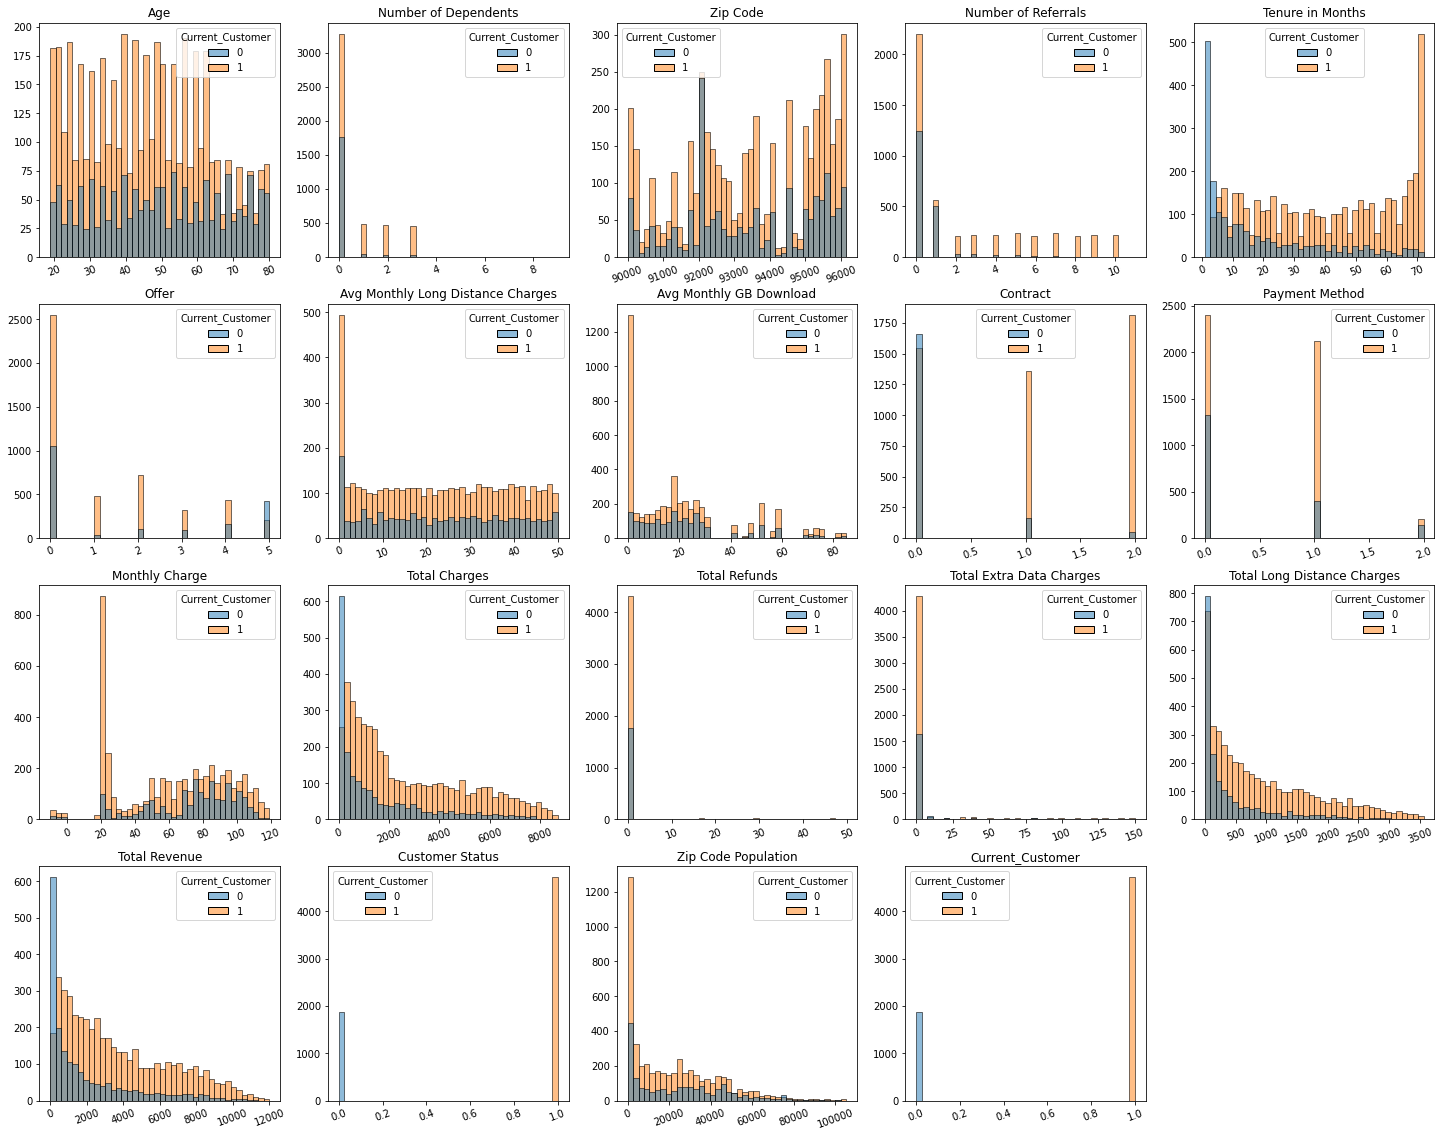

In [26]:
#Revise this chart to make my own
num = [cname for cname in existing_customer_df.columns if existing_customer_df[cname].dtype in ['int64', 'float64']]
df_num = existing_customer_df[num]

fig = plt.figure(figsize = (25, 25))

i = 1
for n in df_num.columns:
    plt.subplot(5, 5, i)
    ax = sns.histplot(x = existing_customer_df[n], hue = existing_customer_df['Current_Customer'], palette = 'tab10', bins = 40)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(n), loc = 'center')
    plt.xticks(rotation = 20, fontsize = 10)
    i += 1

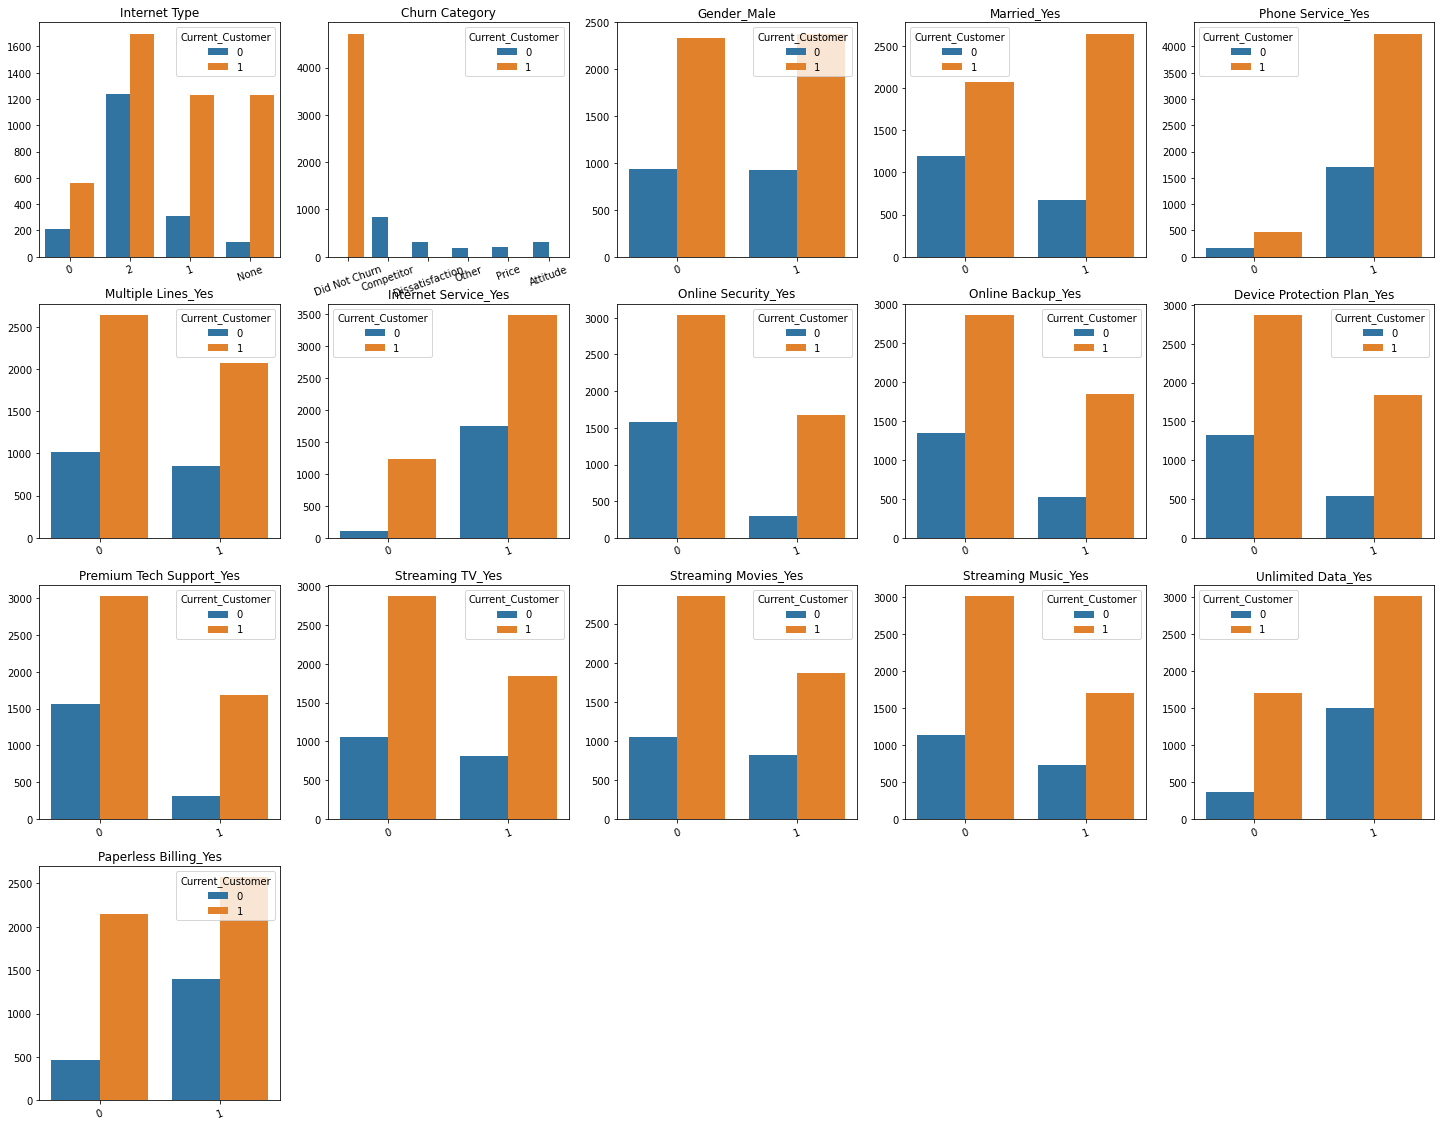

In [27]:
#Revise this chart to make my own
cat = [cname for cname in existing_customer_df.columns if existing_customer_df[cname].nunique() < 10 and existing_customer_df[cname].dtype in ["object", 'uint8']]
dfc_cat = existing_customer_df[cat]

fig = plt.figure(figsize = (25, 25))

i = 1
for c in dfc_cat.columns:
    plt.subplot(5, 5, i)
    ax = sns.countplot(data = dfc_cat, x = dfc_cat[c], hue = existing_customer_df['Current_Customer'], palette = 'tab10')
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(c), loc='center')
    plt.xticks(rotation = 20, fontsize = 10)
    i += 1

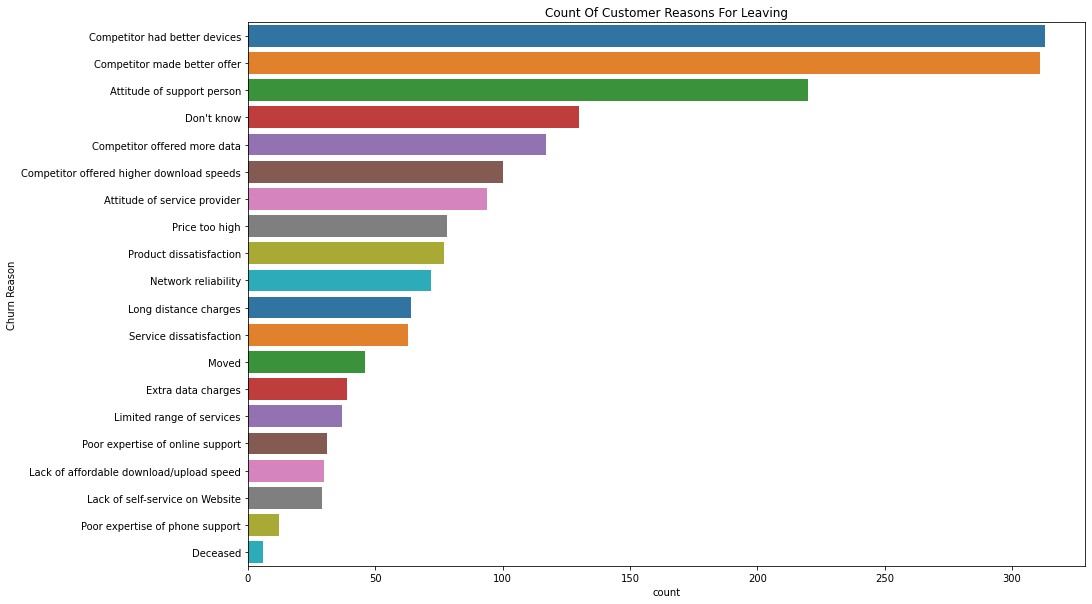

In [28]:
fig = plt.figure(figsize = (15, 10))
churn_df = df[df['Customer Status'] == 0]
ax = sns.countplot(data=churn_df, y='Churn Reason',order = churn_df['Churn Reason'].value_counts().index, palette='tab10')
plt.title('Count Of Customer Reasons For Leaving')
plt.show()

In [29]:
# df.hist(figsize=(15,10))
# plt.subplots_adjust(hspace=0.5);

In [30]:
# churned_df = df[df['Customer Status'] == 'Churned']
# churned_df.hist(figsize=(15,10))
# plt.subplots_adjust(hspace=0.5);

In [31]:
# not_churned_df = df[df['Customer Status'] != 'Churned']
# not_churned_df.hist(figsize=(15,10))
# plt.subplots_adjust(hspace=0.5);

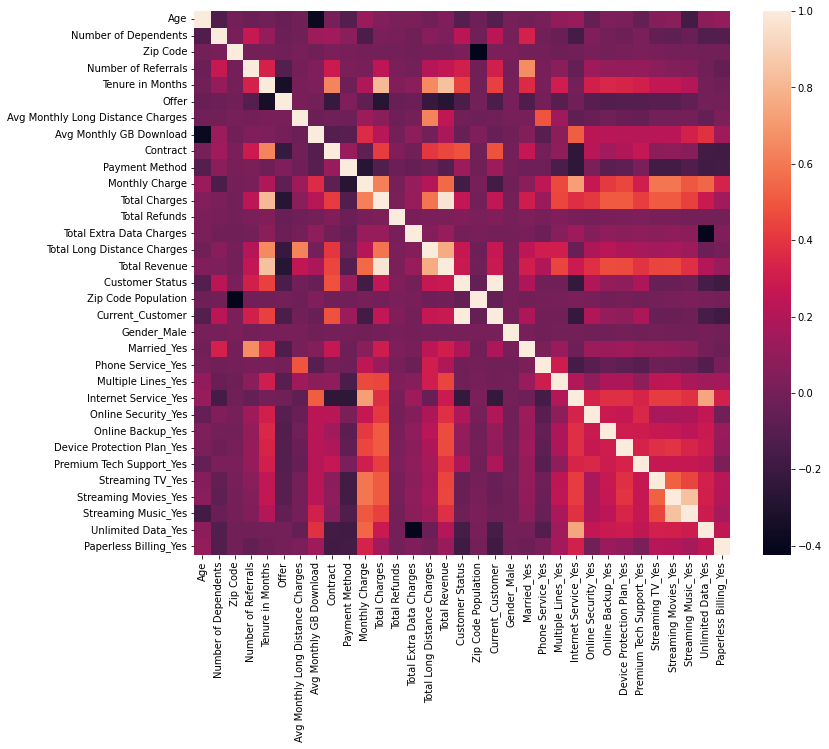

In [32]:
plt.subplots(figsize=(12,10))
sns.heatmap(existing_customer_df.corr());

In [33]:
revenue_by_status = df.groupby('Customer Status')['Total Revenue'].sum()
revenue_by_status

Customer Status
0     3684459.82
1    17632392.12
2       54279.75
Name: Total Revenue, dtype: float64

In [34]:
total_revenue = revenue_by_status.sum()
total_revenue

21371131.69

## 3. Modeling

In [35]:
from pycaret.classification import *

In [36]:
df_ml = df.copy()
df_ml = df_ml[df_ml['Customer Status'] != 2]

In [37]:
df_ml.columns

Index(['Age', 'Number of Dependents', 'Zip Code', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Avg Monthly Long Distance Charges',
       'Internet Type', 'Avg Monthly GB Download', 'Contract',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason',
       'Zip Code Population', 'Current_Customer', 'Gender_Male', 'Married_Yes',
       'Phone Service_Yes', 'Multiple Lines_Yes', 'Internet Service_Yes',
       'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes',
       'Unlimited Data_Yes', 'Paperless Billing_Yes'],
      dtype='object')

In [38]:
df_ml = df_ml.drop(columns=['Churn Category', 'Churn Reason', 'Current_Customer'])

In [39]:
exp_clf101 = setup(data = df_ml, target = 'Customer Status', session_id=123) 

,Description,Value
0,session_id,123
1,Target,Customer Status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6589, 33)"
5,Missing Values,False
6,Numeric Features,25
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8812,0.9405,0.9371,0.9007,0.9185,0.6998,0.7021,0.0550
gbc,Gradient Boosting Classifier,0.8810,0.9413,0.9429,0.8960,0.9188,0.6966,0.7004,0.2990
rf,Random Forest Classifier,0.8699,0.9305,0.9402,0.8849,0.9117,0.6657,0.6705,0.1390
ada,Ada Boost Classifier,0.8686,0.9319,0.9216,0.8973,0.9092,0.6715,0.6728,0.0950
et,Extra Trees Classifier,0.8656,0.9268,0.9277,0.8891,0.9078,0.6596,0.6627,0.1220
lda,Linear Discriminant Analysis,0.8452,0.9085,0.8904,0.8926,0.8915,0.6215,0.6216,0.0300
ridge,Ridge Classifier,0.8448,0.0000,0.8995,0.8851,0.8922,0.6149,0.6154,0.0220
dt,Decision Tree Classifier,0.8333,0.8001,0.8776,0.8877,0.8825,0.5954,0.5960,0.0300
lr,Logistic Regression,0.8051,0.8470,0.8910,0.8446,0.8671,0.5022,0.5051,0.5920
knn,K Neighbors Classifier,0.7283,0.6805,0.8618,0.7805,0.8191,0.2788,0.2848,0.0380


In [41]:
print(best_model)



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [42]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8896,0.9526,0.9576,0.8952,0.9253,0.7146,0.7206
1,0.8506,0.9165,0.9182,0.8783,0.8978,0.6212,0.6233
2,0.8872,0.9485,0.9394,0.9064,0.9226,0.7149,0.7164
3,0.8915,0.9359,0.9605,0.8952,0.9267,0.7193,0.7260
4,0.8829,0.9459,0.9331,0.9056,0.9192,0.7067,0.7078
5,0.9024,0.9474,0.9362,0.9277,0.9319,0.7595,0.7596
6,0.8612,0.9265,0.9271,0.8841,0.9050,0.6475,0.6500
7,0.8915,0.9463,0.9392,0.9115,0.9251,0.7285,0.7295
8,0.8568,0.9336,0.9149,0.8879,0.9012,0.6416,0.6425


In [43]:


tuned_lightgbm = tune_model(lightgbm)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8939,0.9460,0.9576,0.9003,0.9280,0.7271,0.7322
1,0.8506,0.9180,0.9182,0.8783,0.8978,0.6212,0.6233
2,0.8872,0.9369,0.9485,0.8994,0.9233,0.7108,0.7143
3,0.8677,0.9421,0.9271,0.8918,0.9091,0.6664,0.6681
4,0.8764,0.9400,0.9331,0.8977,0.9151,0.6883,0.6900
5,0.9046,0.9492,0.9392,0.9279,0.9335,0.7643,0.7645
6,0.8677,0.9229,0.9331,0.8873,0.9096,0.6632,0.6662
7,0.8872,0.9436,0.9362,0.9086,0.9222,0.7176,0.7187
8,0.8655,0.9312,0.9179,0.8961,0.9069,0.6648,0.6655


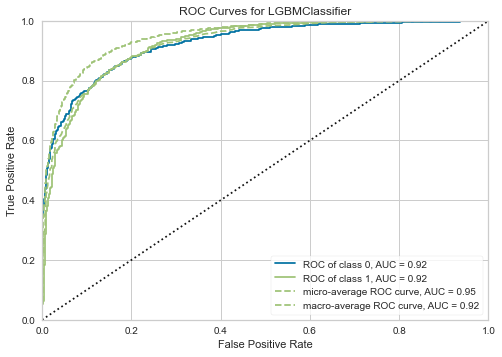

In [44]:
plot_model(tuned_lightgbm, plot = 'auc')

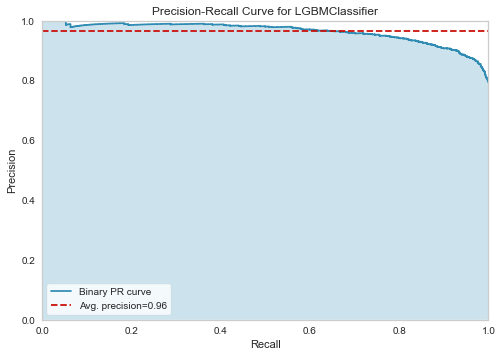

In [45]:
plot_model(tuned_lightgbm, plot = 'pr')

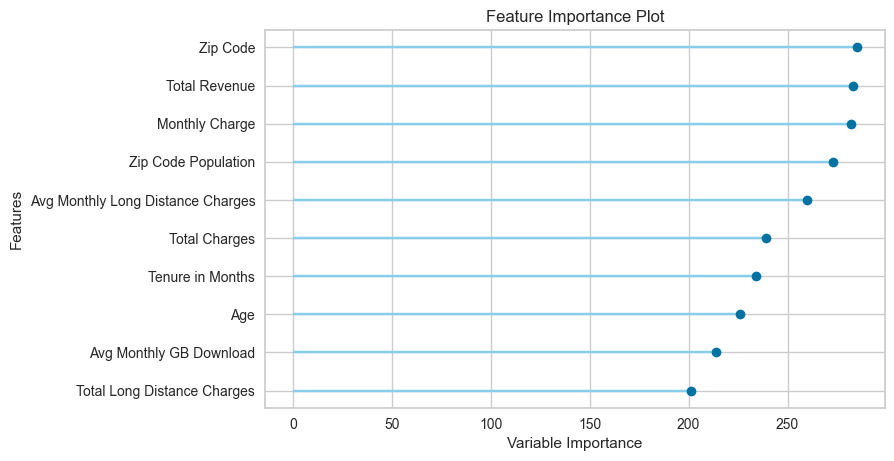

In [46]:
plot_model(tuned_lightgbm, plot='feature')

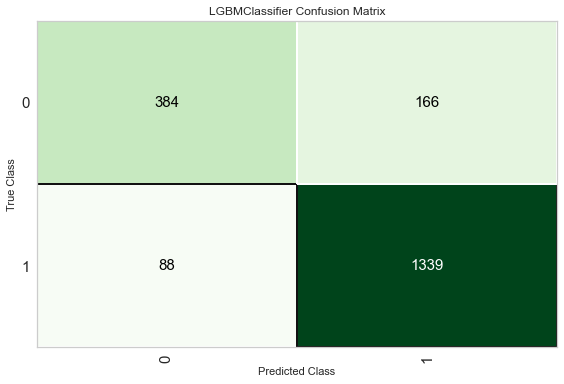

In [47]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [48]:
evaluate_model(tuned_lightgbm)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [49]:
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8715,0.9242,0.9383,0.8897,0.9134,0.6655,0.6691


In [50]:


final_lightgbm = finalize_model(tuned_lightgbm)



In [51]:


predict_model(final_lightgbm);



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9474,0.9912,0.9783,0.9503,0.9641,0.8659,0.8671
